In [9]:
def correct(cont,img):
    #perspective correction
    lig=cont.shape[0]
    cont=cont.reshape(lig,2)
    rect = np.zeros((4,2), dtype="float32")    
    #estimation du quadrilatère
    s = np.sum(cont, axis=1)
    rect[0] = cont[np.argmin(s)]
    rect[2] = cont[np.argmax(s)]
    
    diff = np.diff(cont, axis=1)
    rect[1] = cont[np.argmin(diff)]
    rect[3] = cont[np.argmax(diff)]
    
    (A, B, C, D) = rect
    
    #max(hauteur,largeur) du quadrilatère 
    widthA = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2 )
    widthB = np.sqrt((D[0] - C[0])**2 + (D[1] - C[1])**2 )
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt((A[0] - D[0])**2 + (A[1] - D[1])**2 )
    heightB = np.sqrt((B[0] - C[0])**2 + (B[1] - C[1])**2 )
    maxHeight = max(int(heightA), int(heightB))
    
    #quadrilatère de reference
    dst = np.array([
    [0,0],
    [maxWidth-1, 0],
    [maxWidth-1, maxHeight-1],
    [0, maxHeight-1]], dtype="float32")
    
    #matrice de transformation(quad d'origine --> quad de reference)
    BansformMaBix = cv2.getPerspectiveTransform(rect, dst)
    #transformation affine
    # scan = cv2.warpPerspective(img.copy(), BansformMaBix, (maxWidth, maxHeight),borderMode=cv2.BORDER_REPLICATE)
    
    return cv2.warpPerspective(img.copy(), BansformMaBix, (maxWidth, maxHeight),borderMode=cv2.BORDER_REPLICATE)

In [10]:
def denoise(img):
    blur = cv2.GaussianBlur(img.copy(),(5,5),0)
    return blur

def canny(img):
    edged = cv2.Canny(img.copy(), 75, 200)
    return edged

def detect_ctrs(img):
    
    blur=denoise(img.copy())
    blur=denoise(blur)
    ed1=canny(blur)
    ed1=canny(ed1)
    
    return ed1

In [161]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [258]:
def text_only(img):
    #detect edges 
    ed=detect_ctrs(img)
    pts = np.argwhere(ed>0)
    #crop the text from the starting point (top-left) to end point (bottom-right)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped = img.copy()[y1:y2, x1:x2]    
    return cropped

def pretseg(c):
    # get the contour as arg
    # In some cases, we can get in the same contour many lines of text(case of lines inclined)
    ## Extract all sublines
    kernel = np.ones((5,100), np.uint8)
    p = cv2.dilate(255-c, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(p, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ## find there areas and get the max one (max area==main line)
    area=[]
    im=c.copy()
    for cnt in contours: 
        rect = cv2.minAreaRect(cnt)
        area.append(rect[1][0]*rect[1][1])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
    m=max(enumerate(area),key=lambda x: x[1])[0]
    ## correct the perspective of the line
    rect = cv2.minAreaRect(contours[m])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    ## rect[2]: angle of inclination
    if rect[2]==0:
        return c
    else:
        return correct(box,c)      

def findlimit(bin1):
    bin1=bin1/255
    #finding start and stop of line by transposing the image and starting research from top to bottom
    bin1=bin1.T
    l,c=bin1.shape
    b=np.ones([l,c])
    h=np.sum(bin1,axis=1)
    h=c-h
    start=[]
    stop=[]
    for i in range(l-1):
        if h[i]==0 and h[i+1]!=0 :
            start.append(i+1)
        else:
            if h[i]!=0 and h[i+1]==0 :
                stop.append(i+2)
    return start,stop


def fcat(line,s,st):
    esp=0
    k=1
    #avg of alphabet width in a line --> order to detect existence of space
    space=[]
    for i in range(len(s)-1):
        space.append(s[i+1]-st[i])
    if len(space)==0:
        return 0
    else:
        m=sum(space)/len(space)
       
    for i in range(len(s)-1):
        cropped = line[:,s[i]:st[i]]
        if (np.where(cropped==0)[0].size/cropped.size)>0.08 and 4<cropped.shape[1]<150 :
            cv2.imwrite('line'+ "% s" % i+' caract'+"% s" % k+'.jpg',cropped) 
            k=k+1 
        if s[i+1]-st[i]>m+8 :
            esp+=1
            k=k+1
    cropped = line[:,s[-1]:st[-1]]
    cv2.imwrite('line'+ "% s" % i+' caract'+"% s" % k+'.jpg',cropped) 
    return print('# spaces '+"% s" % esp)

In [270]:
def text_split(thresh):
    im=thresh.copy()
    #dilation
    kernel = np.ones((5,100), np.uint8)
    img_dilation = cv2.dilate(255-thresh, kernel, iterations=1)
    l,c=im.shape
    #find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #sort contours
    #contours = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    contours=np.flip(ctrs,axis=0)
    mask = np.zeros(im.shape, dtype=np.uint8)
    for idx in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[idx])
        # Getting ROI
        roi = im[y:y+h, x:x+w]
        cv2.drawContours(mask, contours, idx,255, -1)
        #ratio of black pixels in surface (w*h)
        r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
        if r > 0.3 and w > 200 and h > 20 and h<0.4*l :
            p=pretseg(roi)
            a,b=findlimit(p)
            ########################################## fcatR ou fcat
            txt=fcat(p,a,b) 
    return txt

In [268]:
img = cv2.imread('binImage.jpg',0)

In [269]:
text_split(img)

[] [1920]
[49, 137, 224, 336, 440, 624, 664, 768, 856, 928] [130, 218, 322, 410, 610, 658, 738, 850, 922, 1097]
# spaces 2


In [241]:
im=cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]


In [215]:
kernel = np.ones((5,5), np.uint8)
img_dilation = cv2.erode(im, kernel, iterations=1)

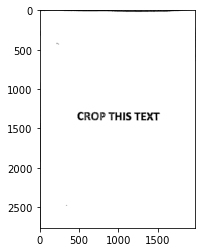

In [242]:
plt.imshow(im,cmap='gray')